# [인물사진 : Shallow focus]

# 1. 주요 개념

- 인물사진 모드 : 피사체(인물)를 가깝게 찍을 때 피사체는 선명하게 나오고 배경은 흐려지는 효과
- 셸러우 포커스 : 아웃포커스라고도 하며, 배경을 흐리게 하는 기법.
- 세그멘테이션(Segmentation) : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법. 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정   
- 시멘틱 세그멘테이션(semantic segmentation) : 사람이 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션. 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법  
- 인스턴스 세그멘테이션(Instance segmentation) : 객체 개개별로 다른 라벨을 가짐. 같은 사람 객체이지만 여러 사람인 경우 각 사람마다 다른 라벨을 부여함.   

# 2. 프로세스 및 함수 등

## (1) 프로세스

① 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다)   
② 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다. DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력(사전학습된 가중치 파일 다운로드)   
③ 블러링(blurring) 기술로 배경을 흐리게 합니다.   
④ 피사체를 배경의 원래 위치에 합성합니다.   

## (2) 주요 함수 등

- applyColorMap() 함수 : 사전학습 가중치로 선별된 객체를 색을 입혀 출력.   
- cv2.resize() 함수 : 세그멘테이션 결과를 원래 크기로 복원    
- cv2.INTER_LINEAR : 크기를 확대할 경우 픽셀 사이에 적당한 색으로 채움.   
- blur()함수 : 이미지를 흐리게 함.   
- bitwise_not 함수 : 객체와 배경을 반전된 값으로 반환.   
- bitwise_and 연산 : 배경만 있는 영상 추출   
- numpy.where() : 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용    

# 3. 코드

## (1) 작업 환경

In [ ]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## (2) 시맨틱 세그멘테이션 다루기 위한 사전학습 가중치 및 함수 생성

### DeepLab 모델을 준비

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, 
    # tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전에 학습된 가중치(pretrained weight) 파일을 다운로드

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/Exploration/08_human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/Exploration/08_human_segmentation/models
model loaded successfully!


### 구글이 제공한 DeepLab은 PASCAL VOC의 라벨 종류

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### '인물사진'과 'blur된 배경' 합성함수 생성

In [ ]:
def shallow_focus(img_orig, object_index, img_concat_name):
    # 입력값 :이미지원본/객체라벨값/합성이미지이름
    
    
    '''  준비한 이미지를 네트워크에 입력  ''' 
    img_resized, seg_map = MODEL.run(img_orig)
    
    '''  입력된 라벨을 가진 영역만 검출  '''
    img_show = img_resized.copy()
    # 예측 중 사람만 추출
    seg_map = np.where(seg_map == object_index, object_index, 0)
    # 255 normalization
    img_mask = seg_map * (255/seg_map.max()) 
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    
    '''세그멘테이션 결과를 원래 크기로 복원하기'''
    # 크기를 확대하면서 보간법을 사용해 픽셀 사이를 채우는 함수인
    # cv2.INTER_LINEAR를 사용.
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    # 경계 blur된 것을 명확히 하기 위해 중간값(128)을 임계값으로 설정
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)  
    
    '''    배경 흐리게 하기    '''
    #(13,13)은 blurring  kernel size를 뜻합니다. 
    img_orig_blur = cv2.blur(img_orig, (13,13)) 
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    '''   흐린 배경과 원본 영상 합성   '''
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    cv2.imwrite( img_concat_name+'_concat.jpg', img_concat)


## (3) 셸로우 포커스 작업

In [ ]:
'''  이미지 원본 읽기   '''
img_path = '/aiffel/Exploration/08_human_segmentation/images/lsc.jpg'  
img_orig = cv2.imread(img_path)

In [ ]:
shallow_focus(img_orig, object_index=15, img_concat_name = 'lsc_c')

# 4. 결과

## (1) 사람과 동물 사진 합성

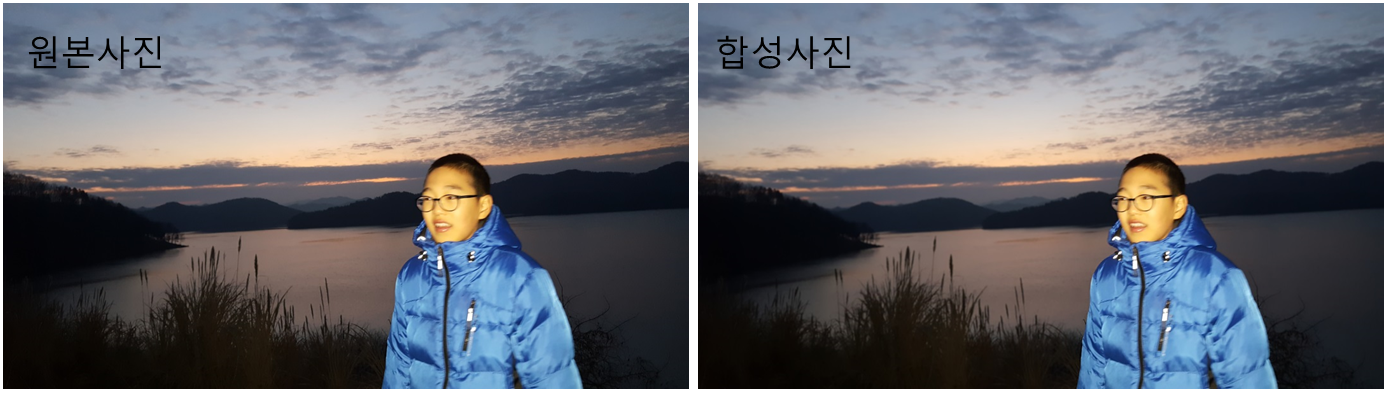

- 원본에 비해 합성사진은 배경이 흐려짐   
- 어두운 배경에 후레시 반사빛이 선명하여 객체 추출이 뛰어남

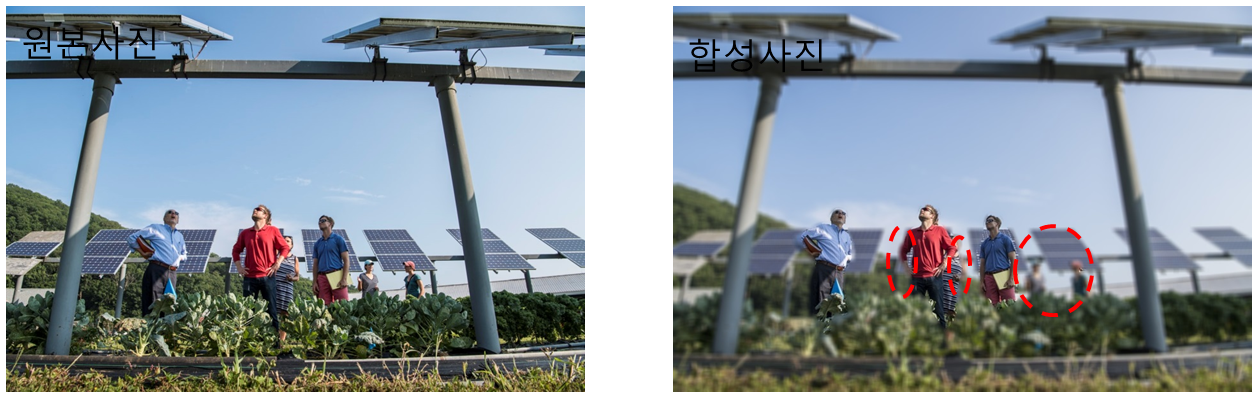

- 배경의 blur효과는 뛰어남. 뒷면 두 명의 사람도 배경으로 처리됨   
- 빨강 티의 사람 팔이 사람 객체와 배경에 모호하게 처리되었고, 빨강 티의 뒤에 있는 여자의 팔도 배경으로 인식됨.

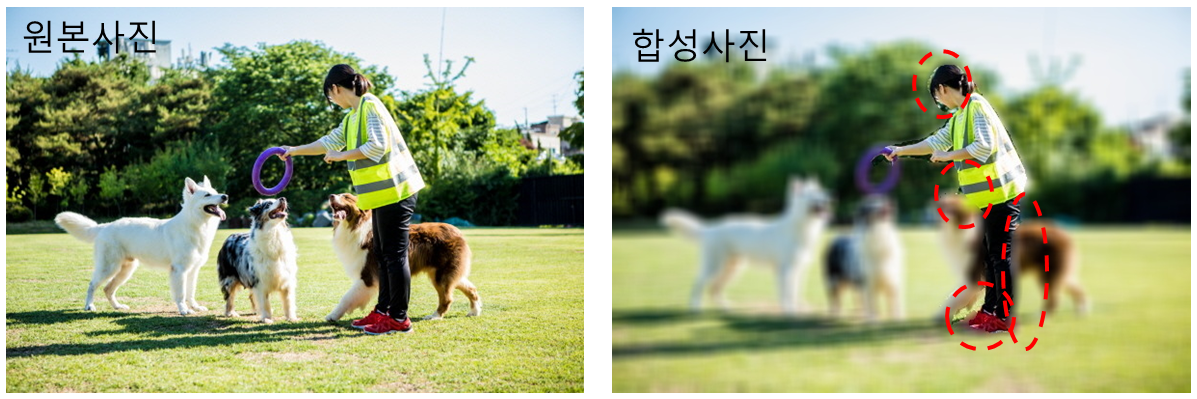

- 사람을 검출 객체로 선정함. 개들도 배경으로 처리됨.   
- 얼굴선이 배경과 섞여 있음.    
- 조끼 하단의 끝이 명확하게 처리되지 못함.   
- 신발과 바지의  경계선이 명확하지 못함.

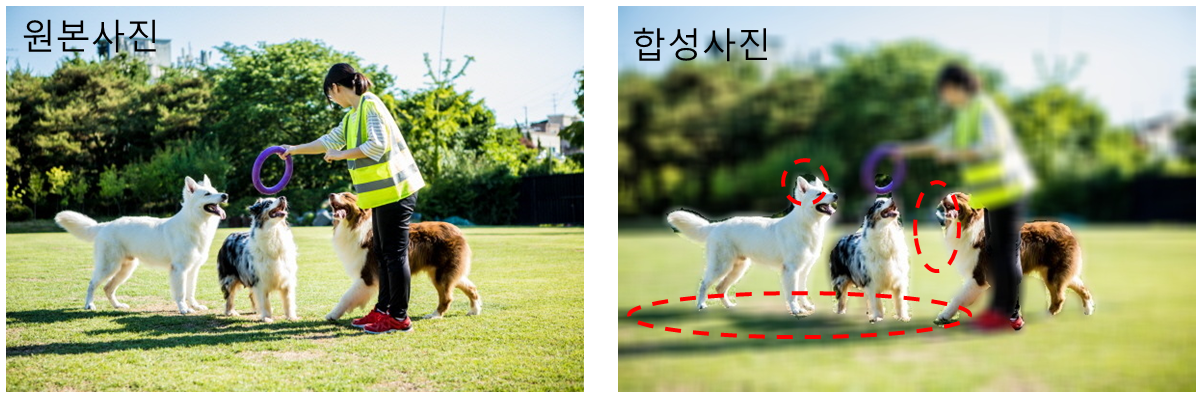

- 개를 검출 객체로 지정하여 사람이 배경처리됨.   
- 개의 머리/귀와 나무의 경계가 부자연스러움.   
- 우측 개의 입선이 배경과 맞물려 부자연스러움.    
- 개의 발 끝이 명확하지 않음    

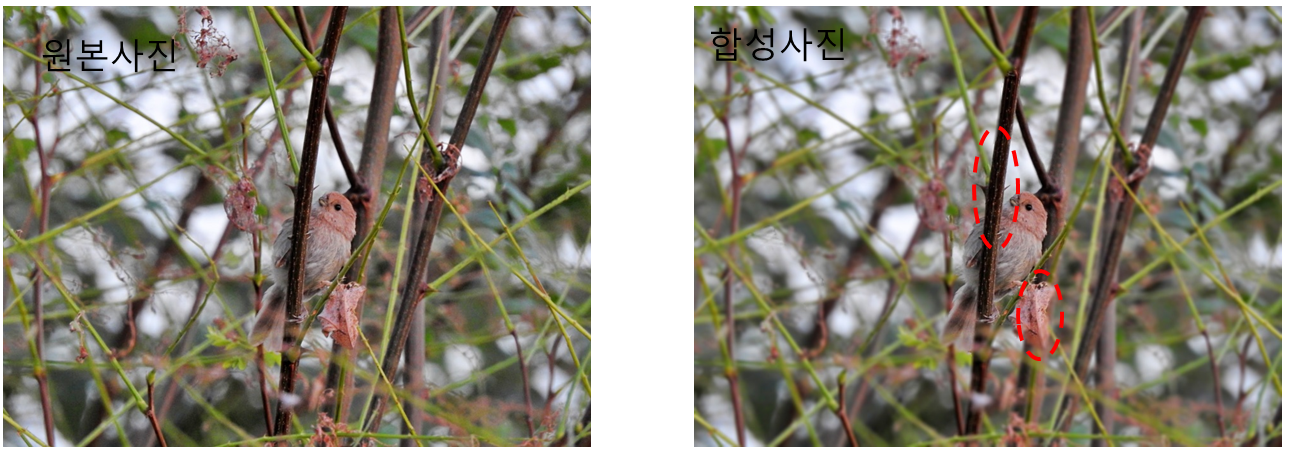

- 새를 검출함.   
- 나무 대롱과 나무잎도 새의 객체로 검출함.   

#### 종합의견

- 객체가 여러 개고, 배경 색과 비슷한 경우, 팔과 같이 가느다란 신체부위, 개의 귀 등이 배경과 혼란을 야기 할 수 있다.   
- 여러 각도의 렌즈로 객체를 이미지화할 경우 객체의 경계를 명확하게 구분할 수 있을 것으로 보임.(별도 장비 필요)    
- 또는 적외선으로 열의 감지로 주변 사물과 동물의 구분을 명확하게 할 수 있을 것이다.(별도 장비 필요)

#### 차후 과제

- 이미지 합성/연산을 숙지하여 추출객체와 다른 배경과 합성하는 작업